In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!git clone https://github.com/Shenggan/BCCD_Dataset.git /content/drive/MyDrive/1Bccd_Dataset


Cloning into '/content/drive/MyDrive/1Bccd_Dataset'...
remote: Enumerating objects: 800, done.
remote: Total 800 (delta 0), reused 0 (delta 0), pack-reused 800 (from 1)
Receiving objects: 100% (800/800), 7.39 MiB | 16.13 MiB/s, done.
Resolving deltas: 100% (378/378), done.
Updating files: 100% (743/743), done.


In [ ]:
pip install ultralytics torch torchvision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 52.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 80.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 54.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 48.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 91.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!pip install xmltodict tqdm


In [ ]:
import os

image_dir = '/content/drive/MyDrive/1Bccd_Dataset/BCCD/JPEGImages'
annotation_dir = '/content/drive/MyDrive/1Bccd_Dataset/BCCD/Annotations'

image_files = os.listdir(image_dir)
annotation_files = os.listdir(annotation_dir)


In [ ]:
images = [os.path.join(image_dir, f) for f in os.listdir(image_dir) if f.endswith('.jpg')]
print(f"Number of images: {len(images)}")


Number of images: 364


In [ ]:
import os
import xml.etree.ElementTree as ET

#
annotation_dir = '/content/drive/MyDrive/1Bccd_Dataset/BCCD/Annotations'
output_dir = '/content/drive/MyDrive/1Bccd_Dataset/BCCD/labels'
image_dir = '/content/drive/MyDrive/1Bccd_Dataset/BCCD/JPEGImages'

# Class mapping
classes = {'RBC': 0, 'WBC': 1, 'Platelets': 2}

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

def convert_to_yolo_format(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    # Get image dimensions
    size = root.find('size')
    image_width = int(size.find('width').text)
    image_height = int(size.find('height').text)

    yolo_annotations = []

    # Iterate through all objects in the annotation
    for obj in root.findall('object'):
        class_name = obj.find('name').text
        if class_name not in classes:
            continue  # Skip unknown classes

        class_id = classes[class_name]
        bbox = obj.find('bndbox')
        xmin = int(bbox.find('xmin').text)
        ymin = int(bbox.find('ymin').text)
        xmax = int(bbox.find('xmax').text)
        ymax = int(bbox.find('ymax').text)

        # Convert to YOLO format
        x_center = (xmin + xmax) / 2 / image_width
        y_center = (ymin + ymax) / 2 / image_height
        width = (xmax - xmin) / image_width
        height = (ymax - ymin) / image_height

        yolo_annotations.append(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}")

    return yolo_annotations

# Process all XML files
for xml_file in os.listdir(annotation_dir):
    if not xml_file.endswith('.xml'):
        continue

    xml_path = os.path.join(annotation_dir, xml_file)
    yolo_annotations = convert_to_yolo_format(xml_path)

    # Save to a YOLO format text file
    txt_filename = os.path.splitext(xml_file)[0] + '.txt'
    txt_path = os.path.join(output_dir, txt_filename)
    with open(txt_path, 'w') as f:
        f.write('\n'.join(yolo_annotations))

print("Conversion completed! YOLO format labels saved.")


Conversion completed! YOLO format labels saved.


In [ ]:
pip install opencv-python pillow matplotlib


In [ ]:
import shutil
from sklearn.model_selection import train_test_split

# Get all images
images = os.listdir(image_dir)
labels = os.listdir(output_dir)

# Keep only images that have labels
images = [img for img in images if img.replace(".jpg", ".txt") in labels]

# Split into train (70%), val (20%), test (10%)
train_imgs, test_imgs = train_test_split(images, test_size=0.2, random_state=42)
train_imgs, val_imgs = train_test_split(train_imgs, test_size=0.1, random_state=42)

# Function to move files
def move_files(files, src_folder, dst_folder):
    os.makedirs(dst_folder, exist_ok=True)
    for file in files:
        shutil.move(os.path.join(src_folder, file), os.path.join(dst_folder, file))

# Move images
move_files(train_imgs, image_dir, "/content/drive/MyDrive/1Bccd_Dataset/BCCD/train/images")
move_files(val_imgs, image_dir, "/content/drive/MyDrive/1Bccd_Dataset/BCCD/val/images")
move_files(test_imgs, image_dir, "/content/drive/MyDrive/1Bccd_Dataset/BCCD/test/images")

# Move corresponding labels
move_files([f.replace(".jpg", ".txt") for f in train_imgs], output_dir, "/content/drive/MyDrive/1Bccd_Dataset/BCCD/train/labels")
move_files([f.replace(".jpg", ".txt") for f in val_imgs], output_dir, "/content/drive/MyDrive/1Bccd_Dataset/BCCD/val/labels")
move_files([f.replace(".jpg", ".txt") for f in test_imgs], output_dir, "/content/drive/MyDrive/1Bccd_Dataset/BCCD/test/labels")


In [ ]:
dataset_dir = "/content/drive/MyDrive/1Bccd_Dataset/BCCD"
data_yaml = f"""train: {dataset_dir}/train/images
val: {dataset_dir}/val/images
test: {dataset_dir}/test/images

augment:
  hsv_h: 0.015  # HSV-Hue augmentation
  hsv_s: 0.7  # HSV-Saturation augmentation
  hsv_v: 0.4  # HSV-Value augmentation
  degrees: 20.0  # Rotation
  translate: 0.1  # Translation (shifting)
  scale: 0.5  # Scaling
  shear: 2.0  # Shearing
  perspective: 0.0  # Perspective distortion
  flipud: 0.5  # Flip vertically
  fliplr: 0.5  # Flip horizontally


nc: 3  # Number of classes
names: ['RBC', 'WBC', 'Platelets']
"""

# Save YAML file
with open(f"{dataset_dir}/data.yaml", "w") as f:
    f.write(data_yaml)

print("✅ `data.yaml` created successfully!")


✅ `data.yaml` created successfully!


In [ ]:
!pip install ultralytics
from ultralytics import YOLO


Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [ ]:
pip install albumentations


In [ ]:
from ultralytics import YOLO

# Load YOLOv10 model
model = YOLO("yolov10n.pt")  # Use "yolov10s.pt" for a larger model

# Train the model
model.train(
    data="/content/drive/MyDrive/1Bccd_Dataset/BCCD/data.yaml",
    epochs=100,
    imgsz=640,
    batch=16
)

from google.colab import files
files.download("runs/detect/train/weights/best.pt")



Ultralytics 8.3.92 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov10n.pt, data=/content/drive/MyDrive/1Bccd_Dataset/BCCD/data.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True

train: Scanning /content/drive/MyDrive/1Bccd_Dataset/BCCD/train/labels.cache... 261 images, 0 backgrounds, 0 corrupt: 100%|██████████| 261/261 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/drive/MyDrive/1Bccd_Dataset/BCCD/val/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]


Plotting labels to runs/detect/train2/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001429, momentum=0.9) with parameter groups 95 weight(decay=0.0), 108 weight(decay=0.0005), 107 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train2
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      3.46G      2.637      6.815      2.804         84        640: 100%|██████████| 17/17 [00:08<00:00,  2.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.26it/s]

                   all         30        419     0.0225      0.654      0.276      0.197



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      3.46G      2.393      4.754      2.358         95        640: 100%|██████████| 17/17 [00:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.36it/s]

                   all         30        419     0.0221      0.645      0.358      0.248



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      3.46G      2.423      3.426      2.349         82        640: 100%|██████████| 17/17 [00:07<00:00,  2.30it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]

                   all         30        419     0.0245       0.63      0.356       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      3.46G      2.404      2.971      2.392        112        640: 100%|██████████| 17/17 [00:05<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         30        419      0.658      0.542      0.437      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      3.46G      2.294      2.678      2.325        150        640: 100%|██████████| 17/17 [00:07<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.27it/s]

                   all         30        419      0.904      0.395      0.533      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      3.46G      2.284      2.514      2.337        109        640: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         30        419      0.897      0.273      0.585      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      3.46G      2.373      2.446      2.351        130        640: 100%|██████████| 17/17 [00:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]

                   all         30        419      0.831      0.516       0.77      0.511



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      3.46G      2.349      2.387      2.354        146        640: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]

                   all         30        419      0.755      0.668      0.813      0.524



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      3.61G      2.278      2.388      2.348         65        640: 100%|██████████| 17/17 [00:06<00:00,  2.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         30        419      0.628      0.818       0.84      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      3.61G      2.177      2.188      2.267        100        640: 100%|██████████| 17/17 [00:05<00:00,  2.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.43it/s]

                   all         30        419      0.709      0.827      0.826      0.566



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      3.61G      2.268      2.157      2.293        122        640: 100%|██████████| 17/17 [00:06<00:00,  2.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.88it/s]

                   all         30        419      0.747      0.817      0.845      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      3.77G      2.236      2.097      2.295        104        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         30        419      0.676      0.778      0.797      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      3.77G      2.203      2.073      2.243        135        640: 100%|██████████| 17/17 [00:05<00:00,  2.99it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.13it/s]

                   all         30        419      0.741        0.8      0.845      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      3.77G      2.197      2.034       2.25         89        640: 100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         30        419      0.851      0.766      0.878        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      3.77G      2.263      2.101      2.327         61        640: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         30        419      0.819      0.784      0.869      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      3.77G        2.2      1.991      2.269         96        640: 100%|██████████| 17/17 [00:06<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.30it/s]

                   all         30        419       0.78      0.821      0.875      0.557



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      3.77G      2.198      1.991      2.262        161        640: 100%|██████████| 17/17 [00:05<00:00,  2.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         30        419      0.785      0.793      0.896      0.598



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      3.77G      2.166      1.915      2.271         73        640: 100%|██████████| 17/17 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.33it/s]

                   all         30        419      0.766      0.876      0.881      0.592



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      3.77G      2.159      1.908       2.25         77        640: 100%|██████████| 17/17 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]

                   all         30        419      0.783      0.737      0.838      0.555



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      3.94G      2.153      1.883      2.257        128        640: 100%|██████████| 17/17 [00:08<00:00,  1.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]

                   all         30        419      0.799      0.783      0.874      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      3.94G      2.158      1.856      2.279        117        640: 100%|██████████| 17/17 [00:05<00:00,  3.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.34it/s]

                   all         30        419      0.736       0.87       0.88      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      3.94G      2.174      1.846      2.274        107        640: 100%|██████████| 17/17 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]

                   all         30        419      0.822      0.823       0.88       0.59



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      3.94G      2.181      1.816      2.264        115        640: 100%|██████████| 17/17 [00:05<00:00,  3.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]

                   all         30        419      0.801      0.834      0.889      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      3.94G      2.123       1.74      2.254         91        640: 100%|██████████| 17/17 [00:06<00:00,  2.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.21it/s]

                   all         30        419      0.833      0.797      0.859      0.576



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      3.94G       2.11      1.754      2.228         81        640: 100%|██████████| 17/17 [00:05<00:00,  3.04it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.69it/s]

                   all         30        419      0.807       0.84      0.872      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      3.94G      2.168      1.782      2.262        166        640: 100%|██████████| 17/17 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         30        419      0.859      0.792      0.888      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      3.94G      2.121       1.72      2.217         76        640: 100%|██████████| 17/17 [00:05<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.72it/s]

                   all         30        419      0.909      0.795      0.903      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      3.94G      2.069      1.613      2.215        103        640: 100%|██████████| 17/17 [00:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.16it/s]

                   all         30        419      0.721      0.879      0.898      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      3.94G      2.097      1.677      2.225        151        640: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         30        419      0.841      0.774      0.901      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      3.94G      2.074      1.625      2.208        132        640: 100%|██████████| 17/17 [00:06<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         30        419      0.854      0.862      0.903      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      3.94G       2.06      1.602      2.222         76        640: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.24it/s]

                   all         30        419      0.864      0.837      0.917      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      3.94G      2.073      1.629      2.224        165        640: 100%|██████████| 17/17 [00:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         30        419       0.85       0.79      0.913      0.618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      3.94G      2.132      1.648      2.242         80        640: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.06it/s]

                   all         30        419      0.822      0.855      0.897      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      3.94G      2.082      1.623      2.236         93        640: 100%|██████████| 17/17 [00:06<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]

                   all         30        419      0.824      0.884      0.904      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      3.94G      2.109       1.58       2.21        100        640: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.44it/s]

                   all         30        419      0.838      0.836      0.892      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      3.94G      2.051      1.568      2.197        105        640: 100%|██████████| 17/17 [00:06<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]

                   all         30        419       0.86      0.836      0.913      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      3.94G      2.048      1.527      2.205        120        640: 100%|██████████| 17/17 [00:05<00:00,  3.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.43it/s]

                   all         30        419      0.822      0.851      0.898      0.619



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      3.94G      2.005      1.523      2.167        160        640: 100%|██████████| 17/17 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         30        419       0.86      0.866      0.915      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      3.94G      2.009      1.509      2.167        146        640: 100%|██████████| 17/17 [00:05<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         30        419      0.854       0.86      0.915      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      3.94G      1.994      1.489      2.177        118        640: 100%|██████████| 17/17 [00:06<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         30        419      0.828      0.858      0.906      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      3.94G      2.019      1.464      2.215        101        640: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.67it/s]

                   all         30        419      0.816      0.911      0.913      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      3.94G      2.042      1.463      2.157        151        640: 100%|██████████| 17/17 [00:05<00:00,  2.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.51it/s]

                   all         30        419      0.825      0.868      0.904      0.621



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      3.94G      2.015       1.44      2.195        123        640: 100%|██████████| 17/17 [00:05<00:00,  2.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         30        419      0.769      0.851      0.884      0.615



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      3.94G      2.033      1.496      2.185        149        640: 100%|██████████| 17/17 [00:05<00:00,  2.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]

                   all         30        419      0.811      0.875      0.906      0.622



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      3.94G      2.001      1.413      2.191         86        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.32it/s]

                   all         30        419      0.865      0.795      0.896      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      3.94G      1.971      1.411      2.168        129        640: 100%|██████████| 17/17 [00:06<00:00,  2.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.55it/s]

                   all         30        419      0.767      0.853      0.878      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      3.94G      1.984       1.43      2.162        113        640: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.58it/s]

                   all         30        419      0.839      0.839      0.891        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      3.94G      1.964      1.399      2.164        138        640: 100%|██████████| 17/17 [00:05<00:00,  2.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         30        419      0.863      0.796      0.891      0.624



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      3.94G      1.954      1.404      2.155        106        640: 100%|██████████| 17/17 [00:06<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.74it/s]

                   all         30        419      0.879      0.859      0.909      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      3.94G      1.985      1.347      2.158        109        640: 100%|██████████| 17/17 [00:05<00:00,  3.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]

                   all         30        419      0.777      0.886      0.893      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      3.94G      1.927      1.375      2.156         91        640: 100%|██████████| 17/17 [00:06<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.54it/s]

                   all         30        419      0.779      0.859        0.9      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      3.94G      1.957      1.375      2.162        117        640: 100%|██████████| 17/17 [00:05<00:00,  3.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.28it/s]

                   all         30        419      0.845      0.863        0.9      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      3.94G      1.918      1.355      2.134        151        640: 100%|██████████| 17/17 [00:06<00:00,  2.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.66it/s]

                   all         30        419      0.824       0.85      0.902      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      3.94G      1.917      1.328      2.161        130        640: 100%|██████████| 17/17 [00:05<00:00,  3.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         30        419      0.819      0.899       0.91      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      3.94G      1.897      1.322      2.131        127        640: 100%|██████████| 17/17 [00:05<00:00,  2.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.18it/s]

                   all         30        419      0.892      0.798      0.904      0.623



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      3.94G        1.9      1.306      2.156        109        640: 100%|██████████| 17/17 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.85it/s]

                   all         30        419      0.837      0.893      0.921       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      3.94G      1.905      1.304      2.136         95        640: 100%|██████████| 17/17 [00:06<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.91it/s]

                   all         30        419        0.8      0.893      0.906      0.625



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      3.94G      1.917      1.266      2.121        166        640: 100%|██████████| 17/17 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.33it/s]

                   all         30        419      0.874      0.813      0.912       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      3.94G      1.907      1.279      2.136        149        640: 100%|██████████| 17/17 [00:06<00:00,  2.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.53it/s]

                   all         30        419      0.866      0.841       0.91      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      3.94G      1.847      1.246      2.089         73        640: 100%|██████████| 17/17 [00:05<00:00,  3.05it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]

                   all         30        419      0.893      0.819      0.915      0.638



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      3.94G       1.85      1.224      2.096        132        640: 100%|██████████| 17/17 [00:06<00:00,  2.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.77it/s]

                   all         30        419      0.809      0.939      0.916      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      3.94G       1.88      1.281      2.134         64        640: 100%|██████████| 17/17 [00:05<00:00,  2.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.30it/s]

                   all         30        419       0.84      0.896       0.92      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      3.94G      1.913      1.251      2.113        121        640: 100%|██████████| 17/17 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.41it/s]

                   all         30        419      0.839        0.9      0.919      0.632



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      3.94G      1.854      1.209      2.108         84        640: 100%|██████████| 17/17 [00:05<00:00,  3.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.30it/s]

                   all         30        419      0.761      0.895      0.903      0.635



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      3.94G      1.898      1.258       2.14        143        640: 100%|██████████| 17/17 [00:06<00:00,  2.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.15it/s]

                   all         30        419      0.832      0.878      0.915      0.643



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      3.94G      1.801      1.197      2.089        131        640: 100%|██████████| 17/17 [00:05<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]

                   all         30        419      0.776      0.833      0.893      0.616



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      3.94G      1.807      1.183      2.096        125        640: 100%|██████████| 17/17 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.54it/s]

                   all         30        419      0.877      0.761      0.888      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      3.94G       1.86       1.22      2.091        116        640: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]

                   all         30        419      0.803      0.903      0.907       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      3.94G       1.81       1.17      2.071        130        640: 100%|██████████| 17/17 [00:06<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.07it/s]

                   all         30        419      0.812      0.883      0.911      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      3.94G      1.838      1.164      2.099        114        640: 100%|██████████| 17/17 [00:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.21it/s]

                   all         30        419      0.842      0.891      0.919      0.653



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      3.94G      1.828      1.192      2.122        158        640: 100%|██████████| 17/17 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]

                   all         30        419      0.814      0.855      0.894      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      3.94G      1.812      1.179      2.086         97        640: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         30        419      0.856      0.836      0.899       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      3.94G      1.813      1.154      2.087        101        640: 100%|██████████| 17/17 [00:06<00:00,  2.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.41it/s]

                   all         30        419      0.858      0.821      0.899      0.641



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      3.94G      1.785      1.125      2.067        121        640: 100%|██████████| 17/17 [00:05<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.08it/s]

                   all         30        419      0.848      0.852      0.907      0.634



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      3.94G        1.8      1.144       2.09        150        640: 100%|██████████| 17/17 [00:06<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.74it/s]

                   all         30        419      0.809      0.886      0.912      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      3.94G      1.773      1.114      2.076        104        640: 100%|██████████| 17/17 [00:05<00:00,  3.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.12it/s]

                   all         30        419      0.897      0.815      0.906      0.631



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      3.94G      1.806      1.145      2.089        116        640: 100%|██████████| 17/17 [00:06<00:00,  2.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]

                   all         30        419      0.856      0.895      0.905      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      3.94G      1.767      1.117      2.057         92        640: 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]

                   all         30        419      0.882      0.864      0.906      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      3.94G      1.767      1.134      2.088         95        640: 100%|██████████| 17/17 [00:06<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.67it/s]

                   all         30        419      0.863      0.873      0.901      0.627



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      3.94G      1.745      1.099      2.065         81        640: 100%|██████████| 17/17 [00:05<00:00,  3.18it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         30        419      0.905      0.822      0.895      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      3.94G      1.757      1.111      2.087        163        640: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         30        419      0.859      0.859        0.9      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      3.94G      1.755      1.108      2.089         86        640: 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.76it/s]

                   all         30        419      0.859      0.874      0.899       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      3.94G      1.701       1.06      2.043        109        640: 100%|██████████| 17/17 [00:06<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]

                   all         30        419      0.882      0.856      0.894      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      3.94G      1.711      1.068      2.053        109        640: 100%|██████████| 17/17 [00:05<00:00,  3.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.40it/s]

                   all         30        419      0.851      0.875      0.901      0.617



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      3.94G      1.696      1.054      2.044        167        640: 100%|██████████| 17/17 [00:06<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]

                   all         30        419      0.872      0.871      0.907      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      3.94G      1.687      1.051      2.036         73        640: 100%|██████████| 17/17 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         30        419      0.882      0.846      0.911      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      3.94G      1.701      1.058      2.049         97        640: 100%|██████████| 17/17 [00:06<00:00,  2.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]

                   all         30        419      0.874      0.865      0.912      0.639



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      3.94G      1.666      1.028      2.028        129        640: 100%|██████████| 17/17 [00:05<00:00,  3.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]

                   all         30        419      0.872       0.85      0.917      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      3.94G       1.67       1.07      2.044         92        640: 100%|██████████| 17/17 [00:07<00:00,  2.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.48it/s]

                   all         30        419      0.858      0.868      0.923      0.644



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      3.94G       1.69       1.03      2.015        156        640: 100%|██████████| 17/17 [00:05<00:00,  3.21it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.96it/s]

                   all         30        419      0.874      0.883      0.925      0.641


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      3.94G      1.648      1.054      2.059         69        640: 100%|██████████| 17/17 [00:07<00:00,  2.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]

                   all         30        419      0.871       0.88      0.918      0.648



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      3.94G      1.654     0.9991      2.081         77        640: 100%|██████████| 17/17 [00:06<00:00,  2.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]

                   all         30        419      0.852      0.862      0.918       0.64



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      3.94G       1.61     0.9731      2.042         59        640: 100%|██████████| 17/17 [00:05<00:00,  3.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]

                   all         30        419      0.852      0.905      0.921      0.636



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      3.94G      1.583     0.9241      2.021         73        640: 100%|██████████| 17/17 [00:06<00:00,  2.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.62it/s]

                   all         30        419      0.852       0.88      0.922      0.637



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      3.94G      1.552       0.91      2.038         75        640: 100%|██████████| 17/17 [00:06<00:00,  2.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  3.14it/s]

                   all         30        419      0.815      0.913       0.91       0.63



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      3.94G      1.571      0.903      2.016         70        640: 100%|██████████| 17/17 [00:06<00:00,  2.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]

                   all         30        419       0.82      0.913      0.908      0.626



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      3.94G      1.553     0.8748      2.019         51        640: 100%|██████████| 17/17 [00:04<00:00,  3.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]

                   all         30        419      0.811      0.913      0.907      0.629



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      3.94G      1.555     0.8871      2.035         66        640: 100%|██████████| 17/17 [00:05<00:00,  3.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.61it/s]

                   all         30        419      0.834      0.873       0.91      0.633



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      3.94G       1.52     0.8448      1.997         54        640: 100%|██████████| 17/17 [00:05<00:00,  3.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]

                   all         30        419      0.847      0.877      0.905      0.628



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      3.94G      1.527     0.8454      2.018         70        640: 100%|██████████| 17/17 [00:05<00:00,  2.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  1.72it/s]

                   all         30        419      0.862      0.869      0.905      0.632



100 epochs completed in 0.212 hours.
Optimizer stripped from runs/detect/train2/weights/last.pt, 5.7MB
Optimizer stripped from runs/detect/train2/weights/best.pt, 5.7MB

Validating runs/detect/train2/weights/best.pt...
Ultralytics 8.3.92 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 125 layers, 2,695,586 parameters, 0 gradients, 8.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


                   all         30        419      0.827      0.895      0.919      0.653
                   RBC         30        362      0.755      0.801      0.851      0.626
                   WBC         30         31      0.879          1      0.993      0.828
             Platelets         16         26      0.848      0.885      0.913      0.505
Speed: 0.2ms preprocess, 2.9ms inference, 0.0ms loss, 0.4ms postprocess per image
Results saved to runs/detect/train2


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import files
import shutil

uploaded = files.upload()  # This will open a file upload dialog

for filename in uploaded.keys():
    shutil.move(filename, "/content/drive/My Drive/1Bccd_Dataset/BCCD")
    print(f"File {filename} moved to Drive folder successfully!")


Saving best.pt to best.pt
File best.pt moved to Drive folder successfully!



image 1/1 /content/drive/MyDrive/1Bccd_Dataset/BCCD/test/images/BloodImage_00000.jpg: 480x640 26 RBCs, 1 WBC, 66.7ms
Speed: 2.6ms preprocess, 66.7ms inference, 0.8ms postprocess per image at shape (1, 3, 480, 640)


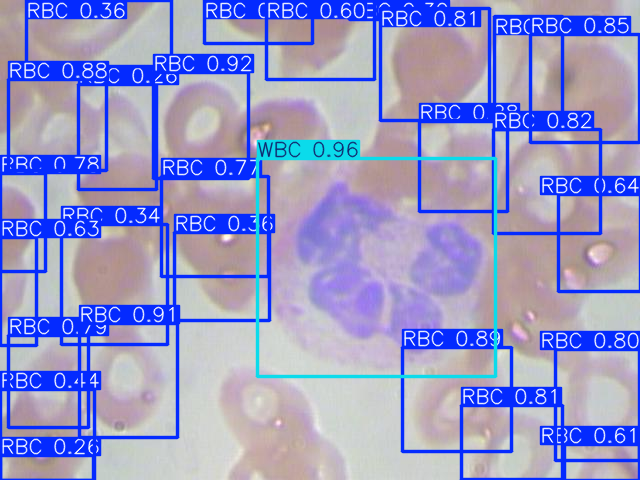

In [ ]:
from ultralytics import YOLO

def detect_objects(image_path, model_path="/content/drive/My Drive/1Bccd_Dataset/BCCD/best.pt"):
    model = YOLO(model_path)
    results = model(image_path)  # Returns a list

    # Access the first result
    result = results[0]

    # Show and save the image with bounding boxes
    result.show()
    result.save("output.jpg")

# Run inference on a test image
test_image = "/content/drive/MyDrive/1Bccd_Dataset/BCCD/test/images/BloodImage_00000.jpg"
detect_objects(test_image)


In [ ]:
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.2/46.2 MB 14.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.2/322.2 kB 27.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 117.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 6.0 MB/s eta 0:00:00


In [ ]:
!pip install ultralytics


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 949.3/949.3 kB 45.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 61.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 87.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 95.3 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
from ultralytics import YOLO
import gradio as gr
import pandas as pd
from PIL import Image
import numpy as np

# Load YOLO model
model_path = "/content/drive/My Drive/1Bccd_Dataset/BCCD/best.pt"
model = YOLO(model_path)  # Load trained model

# Prediction function
def predict(image):
    try:
        # Convert PIL Image to NumPy
        image = np.array(image)

        # Run inference
        results = model(image)

        # Get annotated image with bounding boxes
        img_with_boxes = results[0].plot()  # This returns a NumPy array

        # Extract bounding box data
        pred_data = []
        if results[0].boxes is not None:  # Check if boxes exist
            for box in results[0].boxes.data.tolist():
                x1, y1, x2, y2, conf, cls = box
                pred_data.append({
                    "Class": results[0].names[int(cls)],  # Convert class index to label
                    "Confidence": round(conf, 2),
                    "Bounding Box": f"({int(x1)}, {int(y1)}) - ({int(x2)}, {int(y2)})"
                })

        # Create DataFrame for predictions
        pred_df = pd.DataFrame(pred_data) if pred_data else pd.DataFrame(columns=["Class", "Confidence", "Bounding Box"])

        # Calculate precision & recall manually
        detected_classes = [row["Class"] for row in pred_data]
        unique_classes = set(detected_classes)

        pr_data = []
        for cls in unique_classes:
            tp = detected_classes.count(cls)  # True Positives (detections of class)
            fp = 0  # Assuming no ground truth, FP is zero for now
            fn = 0  # Assuming no ground truth, FN is zero for now
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            pr_data.append({"Class": cls, "Precision": round(precision, 2), "Recall": round(recall, 2)})

        pr_table = pd.DataFrame(pr_data) if pr_data else pd.DataFrame(columns=["Class", "Precision", "Recall"])

        return Image.fromarray(img_with_boxes), pred_df, pr_table

    except Exception as e:
        return f"Error: {str(e)}", None, None

# Gradio Interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Image(type="pil", label="Detected Objects"),
        gr.Dataframe(label="Predictions (Class, Confidence, Bounding Box)"),
        gr.Dataframe(label="Precision & Recall Metrics")
    ],
    title="BCCD Object Detection",
    description="Upload a blood cell image and detect objects using YOLOv10."
)

demo.launch()  # Enable debugging mode


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6d8de0c9a128d390e2.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from ultralytics import YOLO

# Load trained YOLO model
model_path = "/content/drive/My Drive/1Bccd_Dataset/BCCD/best.pt"
model = YOLO(model_path)

# Evaluate model on validation dataset
results = model.val()

# Print the results object to inspect its structure
print("Results Object Type:", type(results))
print("Results Content:", results)

# If results is a list, extract the first element
if isinstance(results, list):
    results = results[0]  # Extract first element




Ultralytics 8.3.93 🚀 Python-3.11.11 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
YOLOv10n summary (fused): 125 layers, 2,695,586 parameters, 0 gradients, 8.2 GFLOPs


val: Scanning /content/drive/MyDrive/1Bccd_Dataset/BCCD/val/labels.cache... 30 images, 0 backgrounds, 0 corrupt: 100%|██████████| 30/30 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.20it/s]


                   all         30        419      0.828      0.887      0.919      0.653
                   RBC         30        362      0.759      0.801      0.852      0.628
                   WBC         30         31      0.876          1      0.993      0.828
             Platelets         16         26      0.848       0.86      0.911      0.504
Speed: 9.9ms preprocess, 6.1ms inference, 0.0ms loss, 0.2ms postprocess per image
Results saved to runs/detect/val5
Results Object Type: <class 'ultralytics.utils.metrics.DetMetrics'>
Results Content: ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7a240e1892d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.00600

In [ ]:
import os
os.environ["LC_ALL"] = "C.UTF-8"
os.environ["LANG"] = "C.UTF-8"


In [ ]:
import locale
def getpreferredencoding(do_setlocale = True):
    return "UTF-8"
locale.getpreferredencoding = getpreferredencoding

In [ ]:
requirements = """
gradio
ultralytics
pandas
Pillow
numpy
"""
with open("requirements.txt", "w") as f:
    f.write(requirements)


In [ ]:
!pip install huggingface_hub
